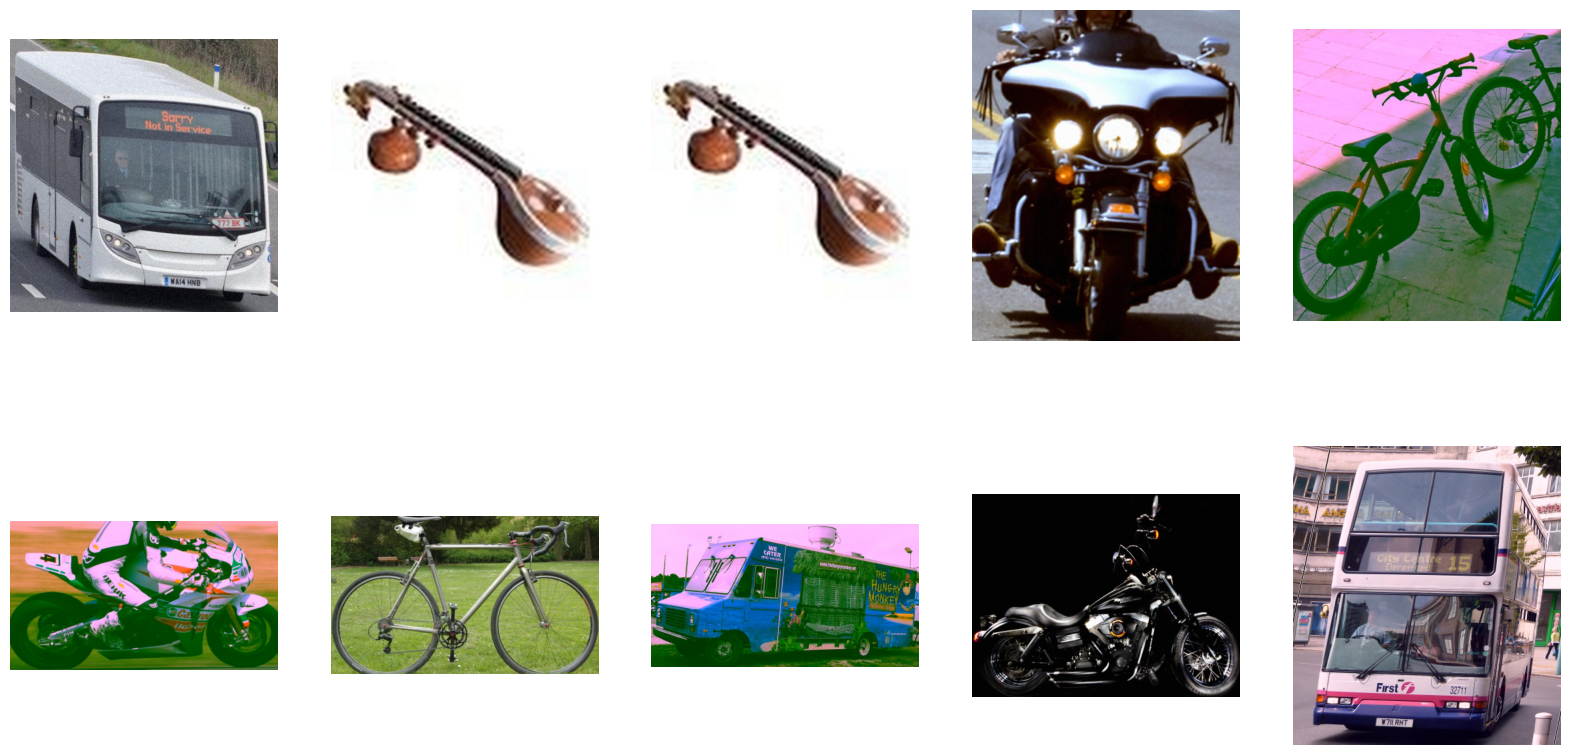

In [2]:

import os
from PIL import Image
import matplotlib.pyplot as plt


image_directory = r"C:\Users\ducta\Downloads\archive\multilabel_modified\images"

image_files = os.listdir(image_directory)


image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

def display_images(image_paths, columns=5, rows=2):
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, columns*rows + 1):
        if i > len(image_paths):
            break
        img = Image.open(os.path.join(image_directory, image_paths[i-1]))
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_images(image_files[:10])

In [3]:
import pandas as pd


LABEL_CSV = r"C:\Users\ducta\Downloads\archive\multilabel_modified\multilabel_classification(6)-reduced_modified.csv"

df = pd.read_csv(LABEL_CSV)
df.head()

,Image_Name,"Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)",motorcycle,truck,boat,bus,cycle,sitar,ektara,flutes,tabla,harmonium
0,image1.jpg,bus,0,0,0,1,0,0,0,0,0,0
1,image2.jpg,sitar,0,0,0,0,0,1,0,0,0,0
2,image3.jpg,flutes,0,0,0,0,0,0,0,1,0,0
3,image4.jpg,bus,0,0,0,1,0,0,0,0,0,0
4,image5.jpg,bus,0,0,0,1,0,0,0,0,0,0


In [5]:
label_cols = ['motorcycle','truck','boat','bus','cycle',
              'sitar','ektara','flutes','tabla','harmonium']

assert all(c in df.columns for c in label_cols), "Some labels are missing!"

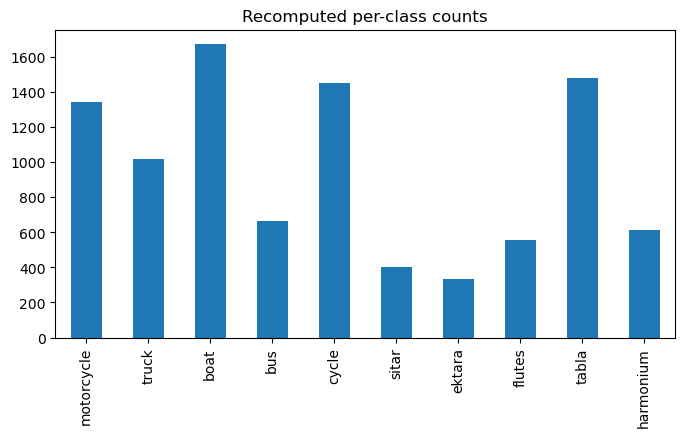

In [6]:
def parse_labels(s):
    return {lbl: 1 for lbl in s.split()}


for lbl in label_cols:
    df[lbl] = df[' Classes(motorcycle, truck, boat, bus, cycle, , , , , , , sitar, ektara, flutes, tabla, harmonium)']\
                 .fillna('')\
                 .apply(lambda cell: 1 if lbl in cell.split() else 0)

df[label_cols].sum().plot.bar(figsize=(8,4))
plt.title("Recomputed per-class counts")
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# split filenames
filenames = df['Image_Name'] 
labels    = df[label_cols].values

# 70% train, 15% val, 15% test
fn_train, fn_temp, y_train, y_temp = train_test_split(
    filenames, labels, test_size=0.30, random_state=42, stratify=labels
)
fn_val, fn_test, y_val, y_test = train_test_split(
    fn_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# build DataFrames
train_df = pd.DataFrame({'filename': fn_train, 'multihot': list(y_train)})
val_df   = pd.DataFrame({'filename': fn_val,   'multihot': list(y_val)})
test_df  = pd.DataFrame({'filename': fn_test,  'multihot': list(y_test)})

print(len(train_df), len(val_df), len(test_df))

5560 1191 1192


In [9]:
from torch.utils.data import Dataset  # Base class for PyTorch datasets
from torchvision import transforms as T  # Preprocessing and augmentation functions
from PIL import Image  # Image processing library
import torch  # PyTorch library for tensor operations

# Define training transformations including resizing, random horizontal flip, converting to tensor, and normalization
train_tfms = T.Compose([
    T.Resize((224, 224)),  # Resize image to 224x224
    T.RandomHorizontalFlip(),  # Data augmentation: randomly flip image horizontally
    T.ToTensor(),  # Convert image to PyTorch tensor
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize tensor using mean and std
])

# Define validation transformations without augmentation
val_tfms = T.Compose([
    T.Resize((224, 224)),  # Resize image to 224x224
    T.ToTensor(),  # Convert image to PyTorch tensor
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize tensor using mean and std
])

class MultiLabelDataset(Dataset):
    """
    Dataset for multi-label classification.
    Each sample includes an image and its corresponding multi-hot encoded label vector.
    """
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)  # Reset index for consistency
        self.img_dir = img_dir  # Directory containing images
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.df)  # Return total number of samples

    def __getitem__(self, idx):
        row = self.df.iloc[idx]  # Get row corresponding to the sample
        # Open image using full path and ensure it's in RGB mode
        img = Image.open(os.path.join(self.img_dir, row.filename)).convert("RGB")
        labels = torch.tensor(row.multihot, dtype=torch.float32)  # Convert multi-hot labels to tensor
        if self.transform:
            img = self.transform(img)  # Apply transformations if provided
        return img, labels  # Return processed image and labels


In [10]:
from torch.utils.data import DataLoader

train_dataset = MultiLabelDataset(train_df, image_directory, transform=train_tfms)
val_dataset   = MultiLabelDataset(val_df, image_directory, transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)

# quick sanity check
imgs, labs = next(iter(train_loader))
print(imgs.shape, labs.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 10])


In [11]:
num_classes = len(label_cols)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)


class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64

        # Initial conv + pool
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )

        # Four “stages” of residual blocks
        self.layer1 = self._make_layer(64,  blocks=2, stride=1)
        self.layer2 = self._make_layer(128, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, blocks=2, stride=2)
        self.layer4 = self._make_layer(512, blocks=2, stride=2)

        # Global pooling + classifier head
        self.avgpool    = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        # first block may downsample
        layers.append(ResidualBlock(self.in_channels, out_channels,
                                    stride=stride, downsample=downsample))
        self.in_channels = out_channels
        # remaining blocks
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        return self.classifier(x)


num_classes = len(label_cols)
model = AdvancedCNN(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
from tqdm import tqdm

def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def eval_one_epoch(loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)
# example run
#rain_loss = train_one_epoch(train_loader)
#val_loss   = eval_one_epoch(val_loader)
#print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

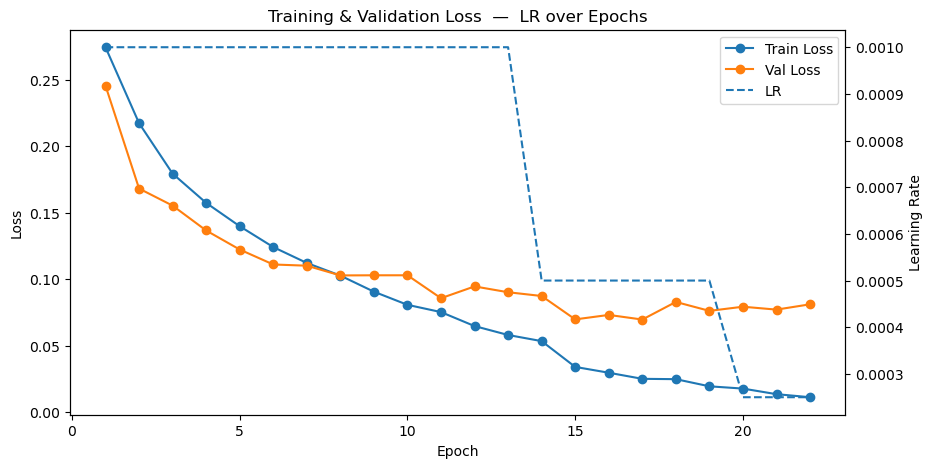

Stopping early at epoch 22 after 5 epochs with no improvement.


In [16]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

patience_es = 5
no_improve_es = 0
best_val_loss = float('inf')

train_losses, val_losses, lr_history = [], [], []
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(train_loader)
    val_loss = eval_one_epoch(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_es = 0
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'opt_state': optimizer.state_dict(),
        }, "best_model.pth")
        print(f"Epoch {epoch}: New best model saved (val_loss={val_loss:.4f})")
    else:
        no_improve_es += 1
        print(f"No improvement for {no_improve_es}/{patience_es} epochs")

    print(f"Epoch {epoch}/{num_epochs} — LR: {current_lr:.2e} — train: {train_loss:.4f}, val: {val_loss:.4f}")
    
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(range(1, epoch+1), train_losses, marker='o', label="Train Loss")
    ax1.plot(range(1, epoch+1), val_losses, marker='o', label="Val Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax2 = ax1.twinx()
    ax2.plot(range(1, epoch+1), lr_history, '--', label="LR")
    ax2.set_ylabel("Learning Rate")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")
    plt.title("Training & Validation Loss  —  LR over Epochs")
    plt.show()

    if no_improve_es >= patience_es:
        print(f"Stopping early at epoch {epoch} after {patience_es} epochs with no improvement.")
        break


In [17]:
with torch.no_grad():
    logits = model(imgs)  # shape (B, C)
    probs  = torch.sigmoid(logits).cpu().numpy()  # probabilities in [0,1]
y_pred = (probs > 0.5).astype(int)

In [18]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Compute the validation set predictions
all_preds = []
all_targets = []
for images, targets in val_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets.numpy())
y_val_prob = np.concatenate(all_preds, axis=0)
y_val_true = np.concatenate(all_targets, axis=0)

best_thresh = {}
for i, lbl in enumerate(label_cols):
    p, r, th = precision_recall_curve(y_val_true[:, i], y_val_prob[:, i])
    f1_scores = 2 * (p * r) / (p + r + 1e-8)
    opt_idx = f1_scores.argmax()
    best_thresh[lbl] = th[opt_idx]
    print(f"{lbl:10s} → best t = {best_thresh[lbl]:.2f}, F1 = {f1_scores[opt_idx]:.3f}")

motorcycle → best t = 0.12, F1 = 0.902
truck      → best t = 0.36, F1 = 0.867
boat       → best t = 0.58, F1 = 0.889
bus        → best t = 0.40, F1 = 0.889
cycle      → best t = 0.57, F1 = 0.916
sitar      → best t = 0.78, F1 = 0.906
ektara     → best t = 0.42, F1 = 0.913
flutes     → best t = 0.34, F1 = 0.951
tabla      → best t = 0.90, F1 = 0.984
harmonium  → best t = 0.27, F1 = 0.950


In [20]:
from sklearn.metrics import average_precision_score, f1_score
from torch.utils.data import DataLoader

# Define test_loader using test_df and the validation transformations
test_dataset = MultiLabelDataset(test_df, image_directory, transform=val_tfms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Run inference on the test set to compute probabilities and true labels
all_test_preds = []
all_test_targets = []
for images, targets in test_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_test_preds.append(preds)
        all_test_targets.append(targets.numpy())
y_prob = np.concatenate(all_test_preds, axis=0)
y_true = np.concatenate(all_test_targets, axis=0)

# Use the existing best_thresh variable
# column order must match label_cols
th_array = np.array([best_thresh[lbl] for lbl in label_cols])

# generate binary predictions using per-class cutoffs
y_test_pred = (y_prob > th_array).astype(int)

# recompute F1 and report
print("Test mAP:", average_precision_score(y_true, y_prob, average="macro"))
print("Test Per-class F1 (with tuned thresholds):")
for i, lbl in enumerate(label_cols):
    f1 = f1_score(y_true[:,i], y_test_pred[:,i])
    print(f"  {lbl:11s}: {f1:.3f}")

Test mAP: 0.9604050822424725
Test Per-class F1 (with tuned thresholds):
  motorcycle : 0.877
  truck      : 0.850
  boat       : 0.885
  bus        : 0.837
  cycle      : 0.907
  sitar      : 0.914
  ektara     : 0.958
  flutes     : 0.982
  tabla      : 0.982
  harmonium  : 0.960


In [26]:
import torch, numpy as np
from PIL import Image
from torchvision import transforms as T

# 1) define transforms
inference_tfms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([.485,.456,.406], [.229,.224,.225]),
])

# 2) load model
model = AdvancedCNN(num_classes=len(label_cols))

# 2) Load its checkpoint:
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state'])          # strict=True by default

# 3) Switch to eval mode and move to device:
model.eval().to(device)

# 3) inference helper
def predict_image(path):
    img = Image.open(path).convert("RGB")
    x   = inference_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = torch.sigmoid(model(x)).cpu().numpy().flatten()
    # map to labels
    preds = {lbl: bool(probs[i] > best_thresh[lbl]) 
             for i,lbl in enumerate(label_cols)}
    return preds
